In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle
from collections import defaultdict
from datetime import datetime
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored

In [2]:
user_profile_path = './data/user_profile.json'
with open(user_profile_path, 'r') as f:
    user_profile = json.load(f)
print(len(user_profile))

624


In [22]:
cnt = 0
for user, profile in user_profile.items():
    if len(profile) > 0:
        cnt += 1
print(cnt)

169


In [3]:
item_information_path = './processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

1216


In [4]:
item_information_dict['2']

{'title': 'Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz',
 'brand': 'Yardley',
 'price': '',
 'description': '\n\nProduct: Shower Gel\nPositive features: Lovely holiday scent, mild scrub, good quality, great smell, works well, fresh fruity scent, creamy suds.\nNegative features: Small size, discontinued.\n\nConcise product description: "Shower Gel with'}

In [5]:
ratings_path = './data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1155081600
1,1,0,5.0,1268697600
2,2,0,5.0,1404604800
3,3,0,5.0,1404604800
4,4,0,5.0,1404604800


In [6]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [16]:
user_profile_summary_prompt_dict = dict()
for user, profile in user_profile.items():
    # print('-'*10)
    # print(user, profile)
    if len(profile) == 0:
        continue
    # print(f"User: {user} Profile: {profile}")
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert beauty product reviewer and recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in list(set(profile))[:15]:
        # print(item)
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User {user} -- Item {item} -- error: {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    prompt += """You are an expert beauty product reviewer and recommender. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
    Do not include information not present in the item descriptions."""
    user_profile_summary_prompt_dict[user] = prompt
    # break
print(len(user_profile_summary_prompt_dict))

User 131 -- Item 399 -- error: index 0 is out of bounds for axis 0 with size 0
User 274 -- Item 399 -- error: index 0 is out of bounds for axis 0 with size 0
169


In [17]:
total_len = 0
all_prompt_lens = []
for user, prompt in user_profile_summary_prompt_dict.items():
    all_prompt_lens.append(len(prompt.strip().split(' ')))
    total_len += len(prompt.strip().split(' '))
print(total_len/len(user_profile_summary_prompt_dict))

224.31360946745562


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 4., 3., 1., 0., 0.,
        2., 2., 0., 8., 5., 1., 5., 0., 8., 4., 1., 0., 2., 2., 5., 0., 0.,
        1., 1., 2., 2., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 2., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        2., 0., 0., 0., 1., 2., 0., 1., 0., 0., 1., 0., 0., 4., 0., 0., 0.,
        1., 3., 2., 0., 2., 2., 2., 1., 0., 1., 1., 2., 0., 1., 3., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

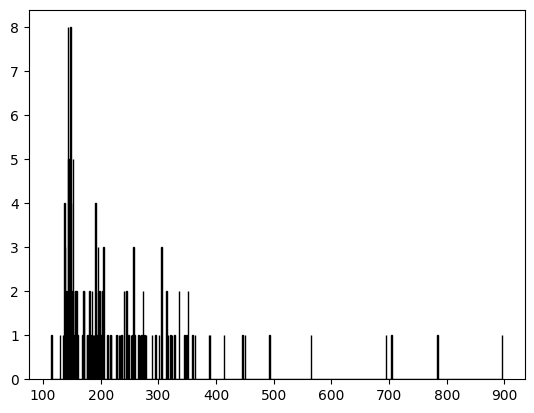

In [18]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [13]:
very_long_prompts_users = list()
for user, prompt in user_profile_summary_prompt_dict.items():
    if len(prompt.strip().split(' ')) > 500:
        very_long_prompts_users.append(user)
print(len(very_long_prompts_users))

8


In [19]:
print(very_long_prompts_users)

['55', '79', '131', '146', '160', '234', '431', '520']


In [20]:
for user in very_long_prompts_users:
    print(user_profile_summary_prompt_dict[user])
    print('-'*100)

You are an expert beauty product reviewer and recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -
Liked Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp; Rich Lather (150 grams) - Raspberry Brand: Pre de Provence Price: $4.99 Description: 

Product: Pre de Provence Soap
Strengths: Delightful, refreshing, rich lather, long-lasting, good value for money, lovely scent, exfoliating
Weaknesses: Scent doesn't last long after use, slightly drying to
Liked Vinolia Cold Cream Bath Soap 170g (1) Brand: Vinolia Price: $6.50 Description: 

The product is a creamy, gentle soap with a delightful scent, suitable for all skin types. However, it may leave soap scum and is relatively expensive.
Liked Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp; Rich Lather

In [32]:
# for user in very_long_prompts_users:
#     user_profile_summary_prompt_dict.pop(user, None)

In [21]:
print(len(user_profile_summary_prompt_dict))

169


In [23]:
user_profile_summary_prompt_path = './data/user_profile_summary_prompt_dict.json'
with open(user_profile_summary_prompt_path, 'w') as f:
    json.dump(user_profile_summary_prompt_dict, f)
    f.close()